In [34]:
import numpy as np
import numpy.lib.recfunctions as recfunctions
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from sklearn.datasets import make_regression

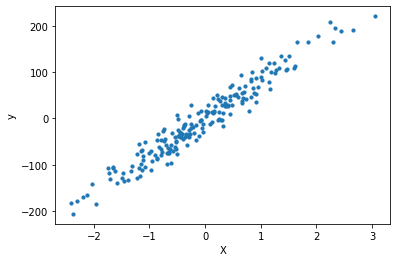

In [35]:
X, y = make_regression(n_samples=200, n_features=1, noise=20, shuffle=False)

def plt_date(X, y, s=10, xlabel='X', ylabel='y'):
    plt.scatter(X, y, s)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plt_date(X, y)

In [36]:
def shuffle_date(X, y, seed=None):
    if seed:
        np.random.seed(seed)
    idx = np.arange(X.shape[0])
    np.random.shuffle(idx)
    return X[idx], y[idx]

def train_test_split(X, y, test_size=0.5, shuffle=True, seed=None):
    if shuffle:
        X, y = shuffle_date(X, y, seed)
    split_i = len(y) - int(len(y) // (1 / test_size))
    X_train, X_test = X[:split_i], X[split_i:]
    y_train, y_test = y[:split_i], y[split_i:]
    
    return X_train, X_test, y_train, y_test 

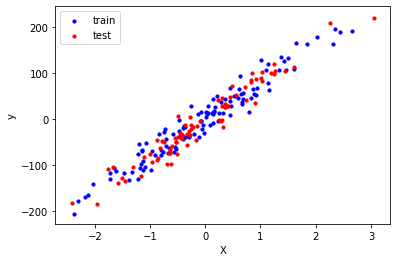

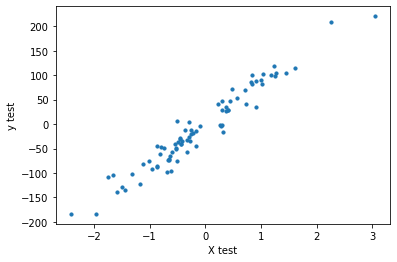

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

poly_degree = 15
fig, ax = plt.subplots()
#X_train.sort(axis=0)
#X_test.sort(axis=0)
ax.scatter(X_train, y_train, label='train', s=10, color='b')
ax.set_xlabel('X')
ax.set_ylabel('y')
ax.scatter(X_test, y_test, label='test', s=10, color='r')
plt.legend()
plt.show()

plt_date(X_test, y_test,xlabel='X test',ylabel='y test')

In [38]:
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

def polynomial_features(X, degree):
    n_samples, n_features = np.shape(X)

    def index_combinations():
        combs = [combinations_with_replacement(range(n_features), i) for i in range(0, degree + 1)]
        flat_combs = [item for sublist in combs for item in sublist]
        return flat_combs
    
    combinations = index_combinations()
    n_output_features = len(combinations)
    X_new = np.empty((n_samples, n_output_features))
    
    for i, index_combs in enumerate(combinations):  
        X_new[:, i] = np.prod(X[:, index_combs], axis=1)

    return X_new

class l2_regularization():
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

In [39]:
class PolynomialRidgeRegression:
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, gradient_descent=True):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
    
    def initialize_weights(self, n_features):
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))
    
    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

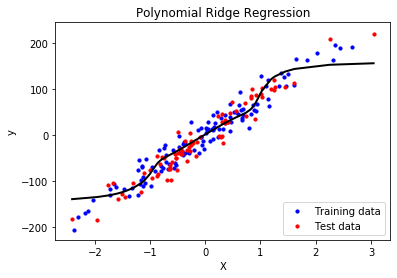

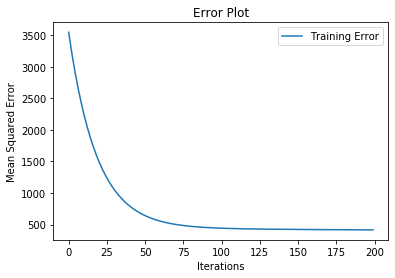

In [40]:
reg_factor = 0.01
model = PolynomialRidgeRegression(degree=poly_degree, 
                                    reg_factor=reg_factor,
                                    learning_rate=0.001,
                                    n_iterations=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

m1 = plt.scatter(X_train, y_train, color='b', s=10)
m2 = plt.scatter(X_test, y_test, color='r', s=10)

items = recfunctions.merge_arrays([X_test,y_pred])
items.dtype.names = ['res', 'key']
items.sort(order=['res'])

plt.plot([items[i][0] for i in range(0,len(y_pred))], [items[i][1] for i in range(0,len(y_pred))], color='black', linewidth=2, label="Prediction")
plt.title("Polynomial Ridge Regression")
plt.xlabel('X')
plt.ylabel('y')
plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
plt.show()

n = len(model.training_errors)
training, = plt.plot(range(n), model.training_errors, label="Training Error")
plt.legend(handles=[training])
plt.title("Error Plot")
plt.ylabel('Mean Squared Error')
plt.xlabel('Iterations')
plt.show()